Coefficients: 
 [[ 0.19152093  0.17215933  0.21844262  0.15796423  0.12322716 -0.10779079]
 [ 0.11649148  0.18301074  0.12448     0.17392152  0.10946995  0.11238495]
 [ 0.09380087  0.1409974   0.19465316  0.12752589  0.16903149  0.08540687]
 [ 0.07026895  0.1123814   0.15012819  0.19731284  0.12414527  0.15082041]
 [ 0.05957684  0.09811116  0.13951852  0.16736499  0.20758347  0.10237051]
 [ 0.0760458   0.08110874  0.11029734  0.14411665  0.16522574  0.18699449]]
Mean squared error: 0.00
Variance score: 0.30


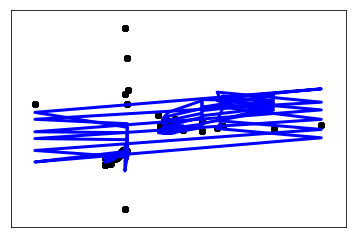

In [154]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes = datasets.load_diabetes()


# Use only one feature
diabetes_X = diabetes.data[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test = diabetes.target[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(df_train_x, df_train_y)

# Make predictions using the testing set
df_y_pred = regr.predict(df_test_x)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(df_test_y, df_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(df_test_y, df_y_pred))

# Plot outputs
plt.scatter(df_test_x, df_test_y,  color='black')
plt.plot(df_test_x, df_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [114]:
import mysql_adactivity_save
import pandas as pd
DATABASE = "dev_facebook_test"

In [135]:
adset_id = 23843319985020240

In [143]:
mydb = mysql_adactivity_save.connectDB(DATABASE)
mycursor = mydb.cursor()
sql = "select * from adset_insights where adset_id={} order by request_time desc limit 360".format(adset_id)
df = pd.read_sql( sql , con=mydb )
mydb.close()

In [144]:
df['minute'] = df.request_time.dt.minute
df['hour'] = df.request_time.dt.hour

In [145]:
df[['target', 'cost_per_target', 'bid_amount','minute','hour']]

,target,cost_per_target,bid_amount,minute,hour
0,323,0.136223,20,25,16
1,311,0.138264,20,15,16
2,307,0.130293,20,5,16
3,301,0.132890,20,55,15
4,301,0.132890,20,45,15
5,296,0.135135,20,35,15
6,296,0.131757,20,25,15
7,291,0.134021,20,15,15
8,291,0.134021,20,14,15
9,291,0.130584,20,5,15


In [146]:
df_train = df['cost_per_target'][-240:].reset_index(drop=True)
df_test = df['cost_per_target'][:-240].reset_index(drop=True)

In [147]:
df_train_x = pd.concat([df_train.shift(-5),df_train.shift(-4),df_train.shift(-3),df_train.shift(-2),df_train.shift(-1),df_train,], axis=1, sort=False)

df_train_y = df_train_x.shift(6).dropna()
df_train_y.drop(df_train_y.tail(5).index,inplace=True)

df_train_x = df_train_x.dropna().drop([0,1,2,3,4,5]).reset_index(drop=True)

In [148]:
df_train_y.head(6)

,cost_per_target,cost_per_target,cost_per_target,cost_per_target,cost_per_target,cost_per_target
6,0.073563,0.075000,0.076063,0.073276,0.074946,0.075356
7,0.076009,0.073563,0.075000,0.076063,0.073276,0.074946
8,0.071253,0.076009,0.073563,0.075000,0.076063,0.073276
9,0.069307,0.071253,0.076009,0.073563,0.075000,0.076063
10,0.071611,0.069307,0.071253,0.076009,0.073563,0.075000
11,0.073491,0.071611,0.069307,0.071253,0.076009,0.073563


In [149]:
df_train_x.head(6)

,cost_per_target,cost_per_target,cost_per_target,cost_per_target,cost_per_target,cost_per_target
0,0.069705,0.073491,0.071611,0.069307,0.071253,0.076009
1,0.068681,0.069705,0.073491,0.071611,0.069307,0.071253
2,0.071633,0.068681,0.069705,0.073491,0.071611,0.069307
3,0.074184,0.071633,0.068681,0.069705,0.073491,0.071611
4,0.070769,0.074184,0.071633,0.068681,0.069705,0.073491
5,0.070288,0.070769,0.074184,0.071633,0.068681,0.069705


In [150]:
df_test_x = pd.concat([df_test.shift(-5),df_test.shift(-4),df_test.shift(-3),df_test.shift(-2),df_test.shift(-1),df_test,], axis=1, sort=False)

df_test_y = df_test_x.shift(6).dropna()
df_test_y.drop(df_test_y.tail(5).index,inplace=True)

df_test_x = df_test_x.dropna().drop([0,1,2,3,4,5]).reset_index(drop=True)

In [151]:
len(df_train_y), len(df_train_x), len(df_test_y), len(df_test_x)

(229, 229, 109, 109)

In [155]:
a=[]

In [157]:
a

[]